# PCA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

from abc import ABC, abstractmethod

plt.style.use('fivethirtyeight')
plt.rc('font', size=8)

## Добавим свою реализацию PCA

In [2]:
class PCA:

    def __init__(self, n_components=None) -> None:
        self._n_components = n_components
        self._x_components = None
        self._cumsum = None

    @property
    def cumsum(self):
        return self._cumsum

    @property
    def n_components(self):
        if self._n_components:
            return min(self._n_components, self._x_components)

        return self._x_components

    @property
    def W(self):
        return self._V[:, :self.n_components]

    @n_components.setter
    def n_components(self, value):
        self._n_components = value

    def fit(self, X, y=None):
        X = np.array(X)
        self._x_components = X.shape[0]

        U, D, Vt = np.linalg.svd(X)
        self._V = Vt.T
        self._cumsum = np.cumsum(D**2 / sum(D**2) * 100)

        return self.cumsum

    def transform(self, X, y=None):
        return np.array(X) @ self.W

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

## Посмотрим как работает PCA

### Классификационная модель из прошлых ноутбуков

In [3]:
def manhattan(x, y):
    x, y = np.array(x), np.array(y)
    return np.sum(abs(x - y), axis=1)

In [4]:
def euclidean(x, y):
    x, y = np.array(x), np.array(y)
    return np.sum((x - y)**2, axis=1) ** (1/2)

In [5]:
def minkowski(x, y, p=2):
    x, y = np.array(x), np.array(y)
    return np.sum(abs(x - y) ** p, axis=1) ** (1/p)

In [6]:
class KNeighbors(ABC):

    def __init__(self,
                 n_neighbors=5,
                 weights='uniform',
                 metric='minkowski',
                 metric_params=None,
                 p=2) -> None:

        self._X = None
        self._y = None

        self._n_neighbors = n_neighbors
        self._weights = weights.lower()
        if self._weights not in ['uniform', 'distance']:
            raise ValueError(f'Unknown value "{weights} for weights param!"')

        if isinstance(metric_params, dict):
            self._metric_params = metric_params
        elif metric_params is None:
            self._metric_params = {}
        else:
            raise TypeError('Unknown param type for metric_params')

        self._distance = None
        if callable(metric):
            self._distance = metric
        elif metric.lower() == 'minkowski':
            self._distance = minkowski
            self._metric_params['p'] = p
        elif metric.lower() == 'manhattan':
            self._distance = manhattan
        elif metric.lower() == 'euclidean':
            self._distance = euclidean
        else:
            raise ValueError(f'Unknown metric {metric} for KNeighbors class!')

    @abstractmethod
    def _predict(self, y, weights):
        return None

    def fit(self, X, y):
        self._X, self._y = np.array(X), np.array(y)
        if self._X.shape[0] != self._y.shape[0]:
            error = 'Found input variables with inconsistent numbers of samples: '  # noqa
            error += f'[{self._X.shape[0]}, {self._y.shape[0]}]'
            raise ValueError(error)

    def predict(self, X):
        return np.apply_along_axis(self._brute_force, 1, np.array(X))

    def _brute_force(self, X):
        distances = self._distance(X, self._X, **self._metric_params)
        prediction = distances.argsort()[:self._n_neighbors]
        weights = self._calc_weights(distances[prediction])
        return self._predict(self._y[prediction], weights)

    def _calc_weights(self, distance):
        if self._weights == 'distance':
            return max(distance) - distance + 0.1

        return np.ones(len(distance))

In [7]:
class KNeighborsClassifier(KNeighbors):

    def _predict(self, y, weights):
        results = []
        predictions = np.unique(y)
        for pred in predictions:
            results.append(sum(weights[y == pred]))

        return predictions[np.array(results).argmax()]

In [8]:
class StandardScaler:

    def __init__(self) -> None:
        self._x_mean = None
        self._x_std = None

    def fit(self, X, y=None):
        X = np.array(X)
        self._x_mean = X.mean(axis=0)
        self._x_std = X.std(axis=0)

    def transform(self, X, y=None):
        if self._x_mean is None or self._x_std is None:
            raise RuntimeError(
                "StandardScaler is not fited (fit method was never called)!"
            )

        X = np.array(X)
        return (X - self._x_mean) / self._x_std

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

In [9]:
def accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / len(y_true)

### Загрузка и подготовка данных

In [10]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
pca = PCA()
print(pca.fit(X_train))

[ 71.24697167  95.18491671  99.48417327 100.        ]


In [13]:
pca.n_components = 2
pca_X_train = pca.transform(X_train)
pca_X_test = pca.transform(X_test)
print(pca_X_train.shape)

(97, 2)


### Обучение модели

In [14]:
results = {
    'n_neighbors': [],
    'acc': [],
    'pca_acc': [],
}

for n_neighbors in range(1, 11):
    results['n_neighbors'].append(n_neighbors)

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(X_train, y_train)
    pred = knn.predict(X_test)
    results['acc'].append(accuracy(y_test, pred))

    knn = KNeighborsClassifier(n_neighbors=n_neighbors)
    knn.fit(pca_X_train, y_train)
    pred = knn.predict(pca_X_test)
    results['pca_acc'].append(accuracy(y_test, pred))

results = pd.DataFrame(results)

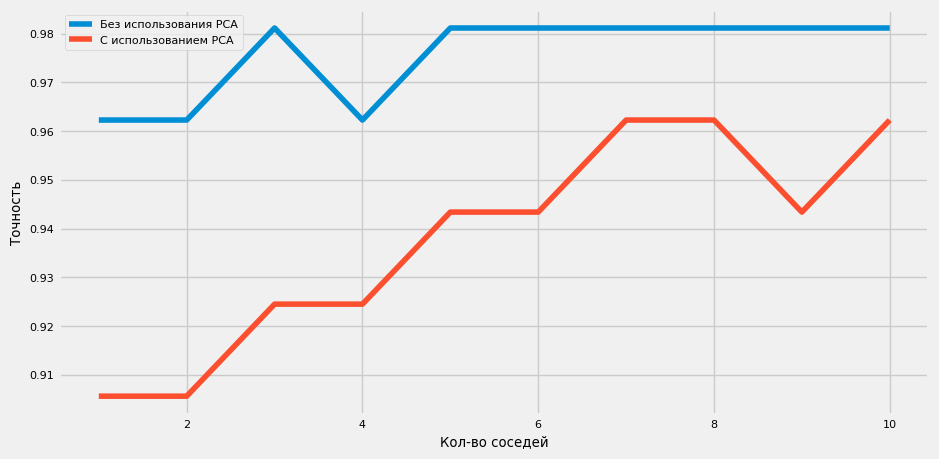

In [15]:
plt.figure(figsize=(10,5))

plt.plot(results['n_neighbors'], results['acc'], label='Без использования PCA')
plt.plot(results['n_neighbors'], results['pca_acc'], label='С использованием PCA')

plt.ylabel('Точность')
plt.xlabel('Кол-во соседей')
plt.grid(True)
plt.legend()

plt.show()

PCA не подходит для отбора признаков т.к. в результате его работы получается матрица, признаки которой состоят из линейных комбинаций признаков исходной. Т.е. PCA не говорит какие конкретно признаки наиболее или наименее значимые, но этот алгоритм позволил убрать 2 столбца из набора данных (половину от исходного датасета) потеряв при этом всего 4.8% информации. Применение PCA снизило точность алгоритма, но позволило понизить размерность данных.